Whilst Spark is amazing at handling big data sets, it isn't a great idea to plot all of it. We suggest taking a maximum of 5% of records for the tutorial. 

You can up it to your requirements, but we recommend sticking to less than 1 million records per month for visualization purposes.

**Project 1 Checklist:**
- You have justified your sample size (i.e due to runtime, distribution of data, etc)
- You have justified your sampling method (i.e random, stratified, etc)
- You have detailed in your report that you have sampled for visualization purposes BUT your analysis still uses the full distribution of data
- You mention any issues that can potentially be caused by sampling (i.e biased visualisation if using random)

Remember, it is your responsibility as the student (future Data Scientist) to convince the tutor (your stakeholders) that your justifications and assumptions are correct!

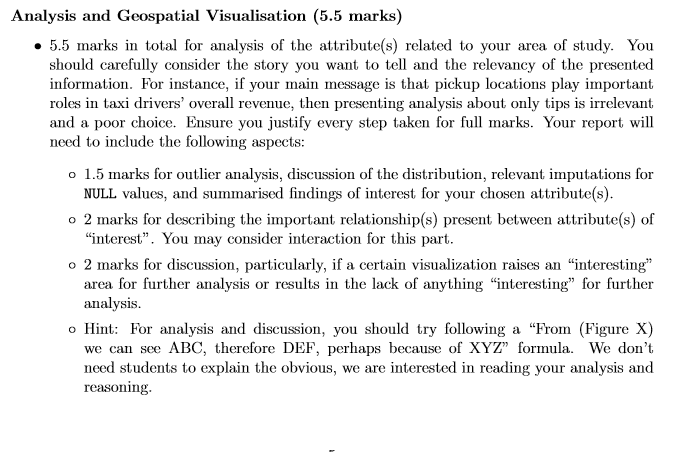

In [86]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC") # fix timestamps loaded by spark
    .getOrCreate()
)

# Exploratory Data Analysis

#### (Note that dataset shape can be distribution and / or dimensionality)

### Outlier analysis, discussion of the distribution, relevant imputations for NULL values, and summarsed findings of interest for the attributes

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#df = spark.read.parquet('../data/curated/combined.parquet')

df = pd.read_parquet('../data/curated/combined_imputed.parquet')



In [14]:
# remove Newark, JFK and LaGuardia Airport entries as it doesn't make sense to perform analysis involving these features on these locations
df = df.loc[~df['locationid'].isin([1, 132, 138])] 

In [15]:
df.head()



,locationid,year,month,day_of_month,hour,day_of_week,avg_usd_per_1/5_mile,avg_usd_per_minute,number_of_trips_here,is_weekday,...,drive_%,carpool_%,transit_%,walk_%,work_at_home_%,avg_commute_mins,private_work_%,public_work_%,self_employed_%,unemployment_%
0,237,2022,5,12,18,5,2.237502,1.596395,258,True,...,12.183333,2.25,30.750,30.70,12.916667,23.15,82.266667,5.333333,11.450,3.450
1,237,2022,5,4,18,4,2.303215,1.656734,249,True,...,12.183333,2.25,30.750,30.70,12.916667,23.15,82.266667,5.333333,11.450,3.450
2,237,2022,5,17,17,3,2.749652,1.522721,229,True,...,12.183333,2.25,30.750,30.70,12.916667,23.15,82.266667,5.333333,11.450,3.450
3,161,2022,5,4,19,4,1.986236,1.531835,278,True,...,4.250000,0.00,21.975,52.85,12.875000,40.25,87.650000,2.925000,9.425,2.575
4,161,2022,5,10,19,3,1.989695,1.438527,285,True,...,4.250000,0.00,21.975,52.85,12.875000,40.25,87.650000,2.925000,9.425,2.575


In [89]:
df.columns

Index(['locationid', 'year', 'month', 'day_of_month', 'hour', 'day_of_week',
       'avg_usd_per_1/5_mile', 'avg_usd_per_minute', 'number_of_trips_here',
       'is_weekday', 'is_public_holiday', 'number_of_trips_nyc',
       'zone_profitability', 'number_of_airbnb_here',
       'avg_daily_airbnb_price_usd', 'number_of_hotels_here',
       'number_of_parking_munimeters_here', 'number_of_subway_stations_here',
       'total_pop', 'avg_income_per_cap', 'poverty_%', 'professional_%',
       'service_%', 'office_%', 'construction_%', 'production_%', 'drive_%',
       'carpool_%', 'transit_%', 'walk_%', 'work_at_home_%',
       'avg_commute_mins', 'private_work_%', 'public_work_%',
       'self_employed_%', 'unemployment_%'],
      dtype='object')

### Check relationship between attributes of interest and miscellaneous external factors

In [17]:
CORR_COLS = [
    #"month", "day_of_month", "hour","day_of_week", 
    "avg_usd_per_1/5_mile", "avg_usd_per_minute",
    "number_of_trips_here", "is_weekday", "is_public_holiday", "number_of_airbnb_here", "avg_daily_airbnb_price_usd", "number_of_hotels_here", "number_of_subway_stations_here", 
    "number_of_parking_munimeters_here", "zone_profitability"
]

pd.set_option('display.max_columns', None)

corr_misc = df[CORR_COLS].corr()



/tmp/ipykernel_835/2389521097.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdGy')


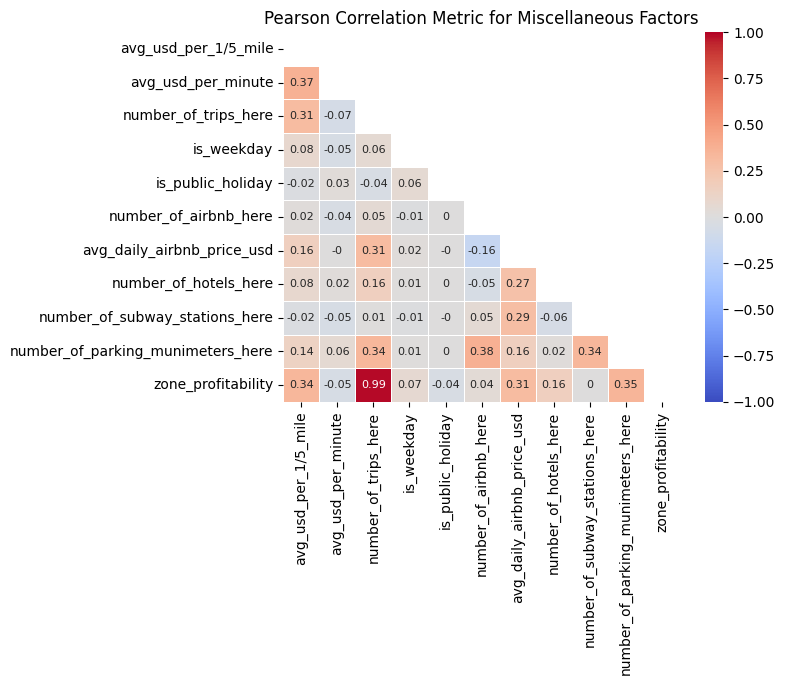

In [18]:
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_misc)

# using the upper triangle matrix as mask 

# Create a custom colormap with shifted white gradient
cmap = plt.cm.get_cmap('RdGy')
reversed_cmap = cmap.reversed()
sns.heatmap(corr_misc.round(2), annot=True, mask=matrix, annot_kws={"size":8}, linewidths=0.5, cmap='coolwarm', vmin=-1, vmax=1)


plt.title('Pearson Correlation Metric for Miscellaneous Factors')
plt.show()


### Check relationship between attributes of interest and job type

In [19]:
CORR_COLS = [
    #"month", "day_of_month", "hour","day_of_week", 
    "avg_usd_per_1/5_mile", "avg_usd_per_minute",
    "number_of_trips_here", 'total_pop', 'avg_income_per_cap', 'poverty_%', 'professional_%',
    'service_%', 'office_%', 'construction_%', 'production_%',
    'zone_profitability'
]

pd.set_option('display.max_columns', None)

corr_job = df[CORR_COLS].corr()


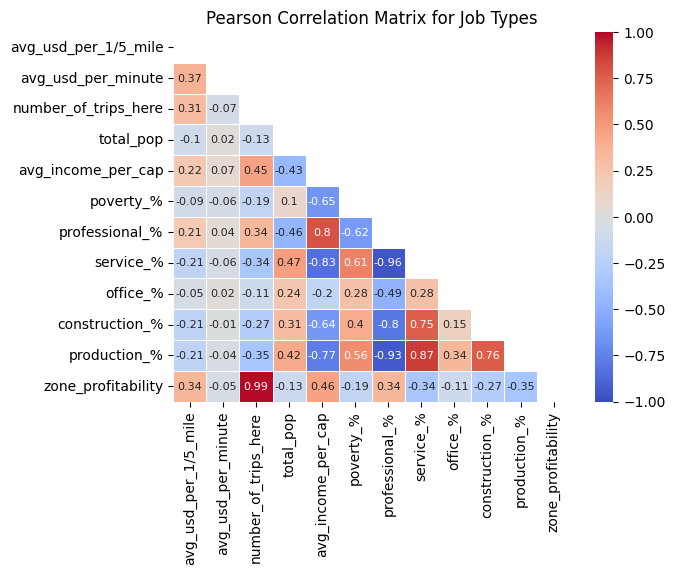

In [20]:
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_job)

# using the upper triangle matrix as mask 
sns.heatmap(corr_job.round(2), annot=True, mask=matrix, annot_kws={"size":8}, linewidths=0.5, cmap='coolwarm', vmin=-1, vmax=1)


plt.title('Pearson Correlation Matrix for Job Types')
plt.show()




### Check relationship between attributes of interest and transport preferences

In [21]:
CORR_COLS = [
    #"month", "day_of_month", "hour","day_of_week", 
    "avg_usd_per_1/5_mile", "avg_usd_per_minute",
    "number_of_trips_here", 'total_pop', 'avg_income_per_cap', 'drive_%',
       'carpool_%', 'transit_%', 'walk_%', 'work_at_home_%',
       'avg_commute_mins', 'zone_profitability'
]

pd.set_option('display.max_columns', None)

corr_transport = df[CORR_COLS].corr()


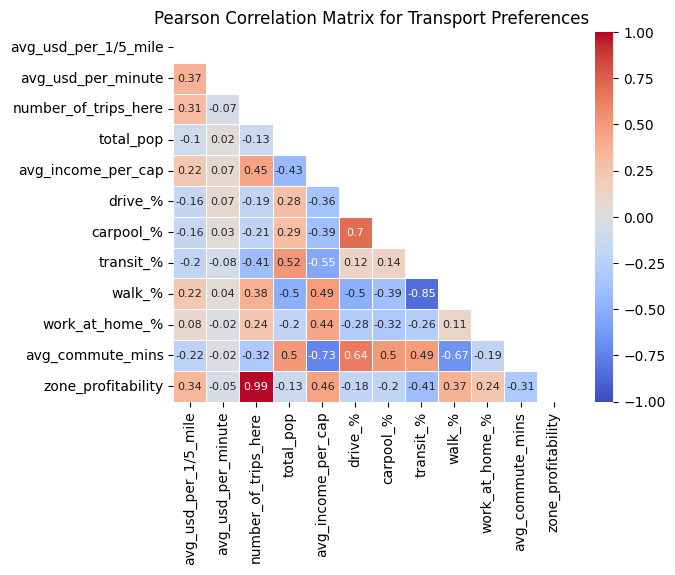

In [22]:
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_transport)

# using the upper triangle matrix as mask 
sns.heatmap(corr_transport.round(2), annot=True, mask=matrix, annot_kws={"size":8}, linewidths=0.5, cmap='coolwarm', vmin=-1, vmax=1)


plt.title('Pearson Correlation Matrix for Transport Preferences')
plt.show()




### Check relationship between attributes of interest and type of employment

In [23]:
CORR_COLS = [
    #"month", "day_of_month", "hour","day_of_week", 
    "avg_usd_per_1/5_mile", "avg_usd_per_minute",
    "number_of_trips_here", 'total_pop', 'avg_income_per_cap', 'private_work_%', 'public_work_%',
       'self_employed_%', 'unemployment_%', 'zone_profitability'
]

pd.set_option('display.max_columns', None)

corr_employment = df[CORR_COLS].corr()


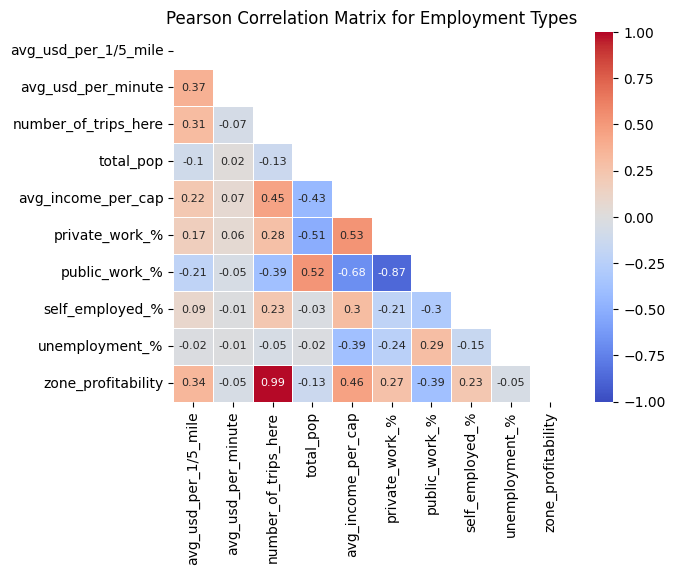

In [24]:
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_employment)

# using the upper triangle matrix as mask 
sns.heatmap(corr_employment.round(2), annot=True, mask=matrix, annot_kws={"size":8}, linewidths=0.5, cmap='coolwarm', vmin=-1, vmax=1)


plt.title('Pearson Correlation Matrix for Employment Types')
plt.show()

### Check correlation between attributes that positively correlate with zone profitability

In [27]:
CORR_COLS = [
    #"month", "day_of_month", "hour","day_of_week", 
    'avg_income_per_cap', 'avg_daily_airbnb_price_usd', 
    'number_of_hotels_here', 'number_of_parking_munimeters_here', 'professional_%',
    'walk_%', 'work_at_home_%', 'private_work_%', 'self_employed_%',
       'avg_commute_mins', 'zone_profitability'
]

pd.set_option('display.max_columns', None)

corr_strong = df[CORR_COLS].corr()


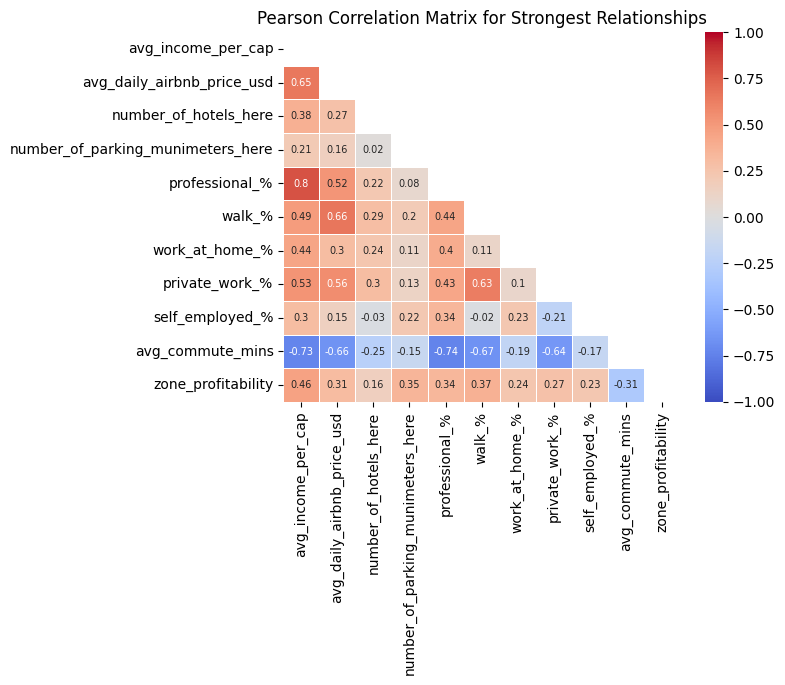

In [28]:
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_strong)

# using the upper triangle matrix as mask 
sns.heatmap(corr_strong.round(2), annot=True, mask=matrix, annot_kws={"size":7}, linewidths=0.5, cmap='coolwarm', vmin=-1, vmax=1)


plt.title('Pearson Correlation Matrix for Strongest Relationships')
plt.show()

#### Being closer to the CBD / locations where the majority of the 'professional' (business and management) jobs are located correlates with higher average income per capita and zone profitability. This could also explain why the percentage of people who claim to prefer walking is higher in these zones, as their workplace is likely within reasonable walking distance for many of them. It seems reasonable to conclude that the wealthier an area is and the higher the amount of private business and management jobs located within it, the more likely taxis are to maximise profit within these areas due to the large taxi demand. It is also worth noting that there is a slight correlation with the number of hotels within an area and taxi profitability, which could likely be explained by the fact that people staying at hotels generally have no means of transportation and would therefore require taxis more often than someone who lives in New York City. The number of parking munimeters being higher within these zones would make sense considering the sheer amount of people working within these zones during the day. It is also assumed that the average daily airbnb price being higher within these zones can be explained by the increased wealth and demand of living / staying in these zones, enabling hosts to charge greater prices for their Airbnbs. Finally, the percentage of people claiming to be self employed or working at home being higher within these areas is likely explained by a greater concentration of business owners being present within these areas. These business owners would identify themselves as self-employed and also be more likely to have the flexibility to work at home.

## Personal Checklist for Visualisations and Dashboards:
1. Your visualisation needs to tell a story.
2. It should be interpretable without being overly verbose.
3. The scale and axis need to make sense (and you can assume the reader knows the difference between a normal scale vs log scale).
4. The choice of visualisation needs to make sense:
    - Line plot vs Bar chart with non-numerical categories
    - Map plot with points vs clusters for each location
    - Scatterplot vs Histogram plot to see distribution
    - etc
5. Choice of colour scheme / alpha / size need to be easy on the eyes.

At the end of the day, even if you think your visualisation is "pretty" or "beautiful", if a reader cannot understand it, then it is not a good visualisation.

Let's go through an example on **pickup locations**.

### Other Visualizations
We recommend that you plot and look at these attributes in your own time using `matplotlib` and `seaborn`.

Scatterplot of `fare_amount` vs `trip_amount`:  
- What's the relationship look like? 
- Why are there many values around 0?
    
    
Histogram and distribution plot of `fare_amount`, `trip_amount`, `trip_distance`:  
- Is the distribution skewed? 
- Does a log transformation make the distribution nicer? 
- What outliers do we have?
- What business rules should I be taking into account?
    
    
Correlation Heatmap between attributes of relevance:  
- Which attributes should we choose? Remember, Pearson's correlation only applies to numerical features and assumes a linear relationship.
- Does correlation imply causality?
    
You may also apply relevant transformations where suitable i.e `log`. Just make sure you **state it clearly** in your figure caption or legend.

A revision of skewness (in case you have forgotten and that's okay):

<img src=https://mammothmemory.net/images/user/base/Maths/Statistics%20and%20probability/Standard%20deviation/skewed-distribution-graphs.c97bc76.jpg alt-text="skew" width=800px>

Things to take note of:
- `trip_distance` highly correlates with high tips, tolls and overall trip amount
- `payment_type` seems to have some form of negative correlation with `tip_amount`. **Be careful as this is a discrete category.**
- Having `VendorID`, `PULocationID`, `DOLocationID`, etc as features **is misleading**, why??? 

**Important:** Only include numerical and ordinal features when computing the Pearson Correlation metric. You cannot compute the correlation between a category and numerical feature (i.e `VendorID` vs `payment_type` vs `trip_distance`).

How about Locations? Does correlation work for it?

- If you're interested in calculating correlation between nominal and continuous data, here's a [great explanation](https://stats.stackexchange.com/questions/119835/correlation-between-a-nominal-iv-and-a-continuous-dv-variable/124618#124618).   
- Remember, you need to refer back to the data dictionary as well as the fare page: https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page

- You should especially take note of the fare page if you're looking to see how `RatecodeID` plays a role on the fare.

## Plot relationships between features / attributes

## Research Goal: 
### - Which type of vehicle driver makes the most money per hour and why
### - Which periods of the year do vehicle drivers make the most money during and why (could use external datasets of when and where social events are occurring which increase taxi / fhv demand)
### - Which regions of NYC do vehicle drivers make the most money during and why
### - How can taxi / fhv drivers maximise tip amounts in general
### - When and where are traffic levels lowest during the year / day for NYC (requires external datasets)

### Could also go the passenger route
### - Which taxi / fhv service provides the cheapest service over the same distance
### - Which taxi / fhv service leads to the most pleasant experience (driver ratings, frequency of sharing with different passengers, wait times, etc.)